In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np 
import os 
import os.path as op 
import sys
from tqdm.notebook import tqdm
import re
import nltk
from nltk.corpus import brown, webtext

nltk.download('brown')
nltk.download('webtext')

sys.path.insert(0, '..') # project folder
from config import * # all paths to files and constants

import time

brown_freq = nltk.FreqDist(brown.words())
webtext_freq = nltk.FreqDist(webtext.words())

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\gbrag\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\gbrag\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!


In [2]:
edu = pd.DataFrame()
for i in range(N_BATCHES):
    batch = pd.read_csv(path_edu.format(i), index_col=0)
    batch = batch.drop(columns = 'description')
    edu = pd.concat([edu, batch])
edu = edu.rename(columns={'channel_id': 'channel', 'categories': 'vid_category'})
channels = pd.read_csv(path_channels, compression="infer", sep="\t")
channels = channels[['channel', 'name_cc', 'category_cc']]
edu = edu[['display_id', 'vid_category', 'channel', 'title', 'tags']]
edu = edu.merge(channels, on='channel', how='left')
#edu.head()

In [3]:
del channels, batch
edu['text'] = edu['title'].fillna('') + ' ' + edu['tags'].fillna('')
edu = edu.drop(columns=['title', 'tags'])

This notebook extracts the subcategories by keyword search using a human and bottom up approach. Since looking for single expressions is way faster than combinations we start by looking at very specific words in the biggest categories (eg. gaming). We proceed with other niche categories that are heavily represented in our observations. Then we group with more complex regular expressions but hopefully on a much smaller dataset. The order of classification is thus important, even crucial. We used personal knowledge, chatGPT, the web, youtube, twitch and copilot to curate the lists of expressions for the categories. Instead of applying complicated patterns with regexp it is preferable to do a big search and then sort out outliers (eg. search for 'python' then sort out all that contain 'animal' and 'snake'). After having run many specific keywords, run the general on the remaining data and try to identify what other keywords one could add.

Since the keywords chosen aim to be specific we need a lot which is where chatGPT and others come in handy

# Pipeline for text processing

In [4]:
def clean_non_word(text): #punctuation, underscores seem to evade this regex so add it
        return  re.sub(r'[^\w\s]|_+', ' ', text)

def clean_non_ascii(text): # indian symbols that might still be left
        return  re.sub(r'[^\x00-\x7F]+', ' ', text)

In [5]:
edu['text'] = edu['text'].apply(clean_non_word).apply(clean_non_ascii)

In [6]:
""" would take 13h - also dangerous since would generalize the words too much
import spacy

tqdm.pandas()
nlp = spacy.load("en_core_web_sm")
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(lemmas)
edu['lemma'] = edu.text.progress_apply(lemmatize)"""

' would take 13h - also dangerous since would generalize the words too much\nimport spacy\n\ntqdm.pandas()\nnlp = spacy.load("en_core_web_sm")\ndef lemmatize(text):\n    doc = nlp(text)\n    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]\n    return \' \'.join(lemmas)\nedu[\'lemma\'] = edu.text.progress_apply(lemmatize)'

In [7]:
edu['category'] = 'unclass'

# Testing

In [8]:
# Sample for testing
# df = edu.sample(frac=0.1, random_state=42, axis =0, ignore_index=True)
# print(len(df))
# keyword = 'audiobook\w*'
# case = False
# pattern = rf'{keyword}' # r"(?=.*\bpython\b)(?=.*\b(programming|program|code|coding)\b)"  
# keyword = df[df.text.str.contains(pattern, case = case, na ='', regex = True)]
# keyword.text.values

# Classsification

In [76]:
listo = ['pubg']

shorto =  [k for k in listo if len(k) <= 4] 
'|'.join([r'\b' + k + r'\b' for k in shorto] + [r'\b' + k + 's' +r'\b' for k in shorto] )

longg = [r'\b' + k + r'\b' for k in listo if len(k) > 4]
shortt = [k for k in longg if len(k) <= 4] 
print('|'.join(shortt+ longg))

In [81]:
def assign_category(keywords:list, case:bool = False, category:str = 'unclass', edu = edu, pre_b = True, w_star = False, post_b = True, bar_text ='search', verbose = False, search_within = 'unclass'):
    pre = ''; post = ''
    if pre_b:  pre = r'\b'
    if post_b: post = r'\b'
    if w_star: post = r'\w*' + post
    if search_within == 'ALL':
        search_range = pd.Series([True]*len(edu))
    else:
        search_range = (edu['category'] == search_within)

    for k in keywords:
        if brown_freq[k.lower()]>5 or webtext_freq[k.lower()]>5:
            print(f'Warning: {k} is a common word: {brown_freq[k.lower()]} in brown and {webtext_freq[k.lower()]} in webtext')
    
    long = [pre + k + post for k in keywords if len(k) > 4]
    short = [k for k in keywords if len(k) <= 4] 
    if short :
        print(f'Warning : Short keywords: {short}')
        short = [r'\b' + k + r'\b' for k in short] + [r'\b' + k + 's' +r'\b' for k in short]

    keywords = '|'.join(long + short)
    pattern = rf'{keywords}'
    start = time.time()
    if verbose: print(pattern)
    edu.loc[search_range & edu.text.str.contains(pattern, case = case, na ='', regex = True) , 'category'] = category
    stop = time.time()
    print(f'{bar_text}: Category {category} now has {len(edu[edu.category == category])} videos, search time: {stop-start:.2f} s')

def detect_left(keywords, edu = edu, case:bool = False, pre_b = True, post_b = True, w_star = False, search_within = 'unclass'):
    if search_within == 'ALL':      df = edu
    else :      df = edu[edu['category'] == search_within]

    pre = ''; post = ''
    if pre_b:  pre = r'\b'
    if post_b: post = r'\b' 
    if w_star: post = r'\w*' + post
    keywords = [pre+k+r'\w*'+post for k in keywords]
    keywords = '|'.join(keywords)
    pattern = rf'{keywords}'
    df = df.loc[df.text.str.contains(pattern, case = case, na ='', regex = True)]
    print(f'Length of the dataframe: {len(df)}')
    return df

### TODO before others

In [12]:
kids = [r"nursery rhyme",r"sing.along",r"Twinkle Twinkle",r"Row Row Row Your Boat",r"Old MacDonald Had a Farm",r"Baa Baa Black Sheep",r"The Wheels on the Bus",r"If You.re Happy and You Know It",r"Itsy Bitsy Spider",r"Five Little Monkey",r"Baby Shark",r"Johnny Johnny Yes Papa",r"London Bridge is Falling Down",r"Head Shoulders Knees",
    r"learn color",'lego duplo', 'count to ten',r"learn shapes",r"learn numbers",r"alphabet songs",r"learn ABC",r"counting songs",r"preschool learning",r"early learning",r"kindergarten",r"how to count",r"learning to read",
    r"Cocomelon",r"Peppa Pig",r"Blippi",r"Baby Shark",r"Paw Patrol",r"Bluey",r"Dora the Explorer",r"Thomas and Friend",r"Masha and the Bear",r"Barney and Friend",r"Teletubb",
    r"kids storytelling",r"family-friendly",r"playtime",r"DIY for kid",r"finger painting",r"pretend play",r"puppet show",
    r"learn animal",r"learn vehicle", r"learn the days",r"learn the months", 'learn animal', r"kid\w* educational song",r"kid\w* song", r"kid\w* dance",r"educational video\w* for kid",r"cartoon\w* for kid", r"bedtime stor",r"kid\w* craft",
    r"kid\w* sing.along",r"kid\w* comedy",r"kid\w* yoga",r"kid\w* exercise",r"kid\w* party song",r"animal sound\w* for kid",r"chil\w+ song",r"bab\w+ song",r"lullab\w+"]
assign_category(kids, case = False, w_star = True, category = '5', bar_text='Kids')

Kids: Category 5 now has 116719 videos, search time: 357.89 s


In [13]:
conspiracy = ['conspiracy', 'Qanon', "hoax", "false flag", "deep state", "new world order", "shadow government", "illuminati",  "psyop ", "plandemic",
              "government mind control","rigged system", "big brother", "surveillance state", "censorship", "black budget", "Area 51",  "crop circles", "ancient aliens",    
              "reptilian", "hollow Earth", "interdimensional beings",  "Bermuda Triangle", "vaccine hoax", "anti-vax", "chemtrails", "pandemic hoax", "climate hoax", "genetic engineering", "eugenics", 
              "population control", "artificial intelligence takeover", "fake science", "JFK assassination", "9.11 inside job", "moon landing hoax", "flat Earth",'flatist', "holocaust denial", "Freemason", 
              "Zionist conspiracy", "Operation Northwoods", "pizzagate", "mass media manipulation", "mass surveillance", "robot uprising", 
              "the occult", "satanic ritual", "luciferian", "black magic", "symbolism", "numerology", "astrology conspiracy", "esoteric knowledge", "deep state"
              "occult rituals", "secret worship", "paganism cover-up", "Epstein island","Q drop", "Q clearance", "The Storm", "The Great Awakening","WWG1WGA","elite cabal", "pedo ring", "adrenochrome",  "Great Reset",
              "Hollywood pedophiles","media lie", "sheeple", "Guantanamo Bay", "red October"]

extra = ["birds aren.t real", "moon landing hoax", "lizard people", "bigfoot sightings", "aliens are real", "area 51 raid"] 

assign_category(conspiracy + extra, case = False, w_star = True, category = 'q', bar_text = 'Conspiracy')
assign_category(extra, case = False, category = 'q', bar_text = 'Conspiracy', search_within='ALL')

Conspiracy: Category q now has 50564 videos, search time: 408.61 s
Conspiracy: Category q now has 50565 videos, search time: 50.58 s


In [79]:
edu.loc[edu.category == '94', 'category'] = 'unclass'

In [80]:
assign_category(['roblox'], category = '91', bar_text='Roblox')
assign_category(['minecraft'], w_star = True, category = '92', bar_text='Minecraft')
assign_category(['pubg'], category = '94', bar_text='PUBG')
assign_category(['league of legend'],w_star = True, category = '95', bar_text='LoL')
assign_category(['call of duty'],w_star = True, category = '96', bar_text='CoD')
assign_category(['super mario', 'mario kart'],w_star = True, category = '97', bar_text='Super Mario')
assign_category(['pokemon'],w_star = True, category = '98', bar_text='Pokemon')

\bpubg\b|\bpubgs\b
PUBG: Category 94 now has 636 videos, search time: 41.05 s
\bleague of legend\w*\b
LoL: Category 95 now has 569 videos, search time: 85.39 s
\bcall of duty\w*\b
CoD: Category 96 now has 1774 videos, search time: 47.55 s
\bsuper mario\w*\b|\bmario kart\w*\b
Super Mario: Category 97 now has 1248 videos, search time: 41.40 s
\bpokemon\w*\b
Pokemon: Category 98 now has 1677 videos, search time: 28.96 s


In [82]:
assign_category(['audiobook'], case = False, w_star = True, category = 'a',bar_text= 'Audiobooks')
assign_category(['wwii', 'wwi'], case = False, category = '20',bar_text= 'World wars')
assign_category(['lifestyle'], case = False, category = 'life', bar_text='Lifestyle')

Audiobooks: Category a now has 4845 videos, search time: 42.51 s
World wars: Category 20 now has 7258 videos, search time: 39.00 s
Lifestyle: Category life now has 16346 videos, search time: 44.37 s


### Programming

In [83]:
ml = [r'neural network', r'Deep Learning', r'Support Vector Machine', r'K.Nearest', r'K.mean', r'Random Forest', r'Markov Chain', r'AdaBoost', r'Hyperparameter', r'Overfitting', r'Gradient Descent', r'Loss Function',
      "decision tree", "random forest", "gradient boosting","naive bayes","transformer", "autoencoder", "generative adversarial network", 
    "backpropagation", "gradient descent", "adam optimizer","apriori algorithm","Markov chain",  "Q-learning", "deep Q-network", "feature engineering", "batch normalization","one-hot encoding", "cross.val", "grid search", "hyperparameter tuning", "regulariz", "self.supervised learning",
    "zero.shot learning", "few.shot learning", "unsupervised learning", "supervised learning", "reinforcement learning", "TensorFlow", "PyTorch", "Keras", "Scikit.learn", "XGBoost", "LightGBM", "CatBoost",
    "FastText","OpenAI","underfit", "overfit",  "F1 score", "ROC curve", "log loss","natural language processing", "sentiment analysis", 'nltk', r'lemmati\w+'
]

coding = [r'Javascript', r'HTML', r'CSS', r'C\+\+', r'matlab', r'web development', r'software development', r'github', r'http', r'Docker', r'Vscode', r'numpy', r'matplotlib', r'ggplot', r'plotly',
    "Kotlin", "Haskell", "Clojure", "TypeScript", "COBOL", "Objective-C","Ruby on Rails", "ASP.NET", "Next.js", "Nuxt.js", "SvelteKit", "Vue.js", "Ember.js", "GraphQL", "MobX",
    "OpenGL", "DirectX", "Three.js", "Anime.js", "MXNet", "Theano", "Chart.js", "object.oriented", "memoization", "DevOps",'kotlin'
    "containerization", "virtual machine", "backend", "frontend", "fullstack", "MongoDB", "PostgreSQL", "SQLite", "MariaDB", "CouchDB",
    "DynamoDB", "Neo4j","Elasticsearch", "Bigtable", "debugger", "WebSocket", "IP routing", "OpenSSH","WebAssembly",
]

case_sensitive = [r'AWS', r'OpenCV', r'SQL',"HDFS","PyQT","D3.js"]

assign_category(ml, case = False, w_star = True, category = '41', bar_text = 'ML')  
assign_category(coding, case = False, category = '4', bar_text = 'All programming')
assign_category(case_sensitive, case = True, category = '4', bar_text = 'Case sensitive')
assign_category(['SQL'], case = False, category = '4', bar_text = 'SQL', pre_b=False, post_b=False)

ML: Category 41 now has 5010 videos, search time: 600.45 s
All programming: Category 4 now has 39538 videos, search time: 456.48 s
Case sensitive: Category 4 now has 42821 videos, search time: 41.27 s
SQL: Category 4 now has 43659 videos, search time: 42.77 s


In [84]:
extra_prog = ['command prompt', 'codeblocks', 'program[a-zA-Z]* tutorial', 'mysql', 'unreal engine', 'VBscript', 'VB net', 'c sharp', 'for loop', 'if clause',
         r'python program[a-zA-Z]*', r'c program[a-zA-Z]*', r'java program[a-zA-Z]*', r'cnc program[a-zA-Z]*',r'unity\s*3d',  'unity\s*2d', 'unity c', 'raspberry pi', 'arduino', 'visual studio code', 'geeksforgeeks','PERL ', 
         'wordpress','PHP','scala ', 'xml', 'gamedev', r'vmc program[a-zA-Z]*', 'clever programmer','blender 2', 'autodesk', 'excel ', 'codecademy', r'R program[a-zA-Z]*', 'install python', 'wxpython', 'javafx', 'cherrypy',"dimensionality reduction", "principal component analysis", "t-SNE", "data preprocessing", "data pipeline"]
assign_category(extra_prog, case = False, category = '4', bar_text = 'Extra programming')

Extra programming: Category 4 now has 94322 videos, search time: 386.45 s


In [85]:
# left_programing = detect_left(['programming', 'coding','python'], case = False)
assign_category(['android'], case = False, category = 'android', bar_text = 'android', pre_b=False, post_b=False)
assign_category(['programming', 'coding', 'python'], case = False, category = '49', bar_text = 'Extra programming')
# left_programing.to_csv(op.join('keys', 'left_programing.csv'))

android: Category android now has 21188 videos, search time: 41.16 s
Extra programming: Category 49 now has 22027 videos, search time: 63.83 s


# Gaming

In [86]:
games = ['tetris', 'Grand Theft Auto', 'stardew valley', 'terraria', 'Elden Ring', 'zelda', 'overwatch', 'Counter.Strike', 'elder scrolls', 'skyrim', 'World of Warcraft', 'apex legends', 'Dead by Daylight', 'EA SPORTS', 'Hearthstone', 'Rainbow Six',
    'battle royale', 'sandbox game','idle game', 'shooter game', 'simulation game', 'arcade','open-world game', 'dungeon crawler', r'VR game\w*'
    'Red Dead Redemption', 'The Last of Us', 'Bioshock', 'Minecraft', 'Dark Souls', 'Hollow Knight', 'Mass Effect', 'Genshin Impact', 'Fire Emblem', 'Monster Hunter','Xenoblade Chronicles', 'Pikmin', 'gaming mouse', 
    'VR headset', 'racing wheel', 'arcade stick','gaming chair', 'RGB lighting','gaming monitor', 'anti-ghosting keyboard', 'haptic feedback controller',
    'streaming deck','console dock', 'GameCube', 'Dreamcast', 'Steam Deck','Atari', 'Commodore 64', 'Sega Genesis', 'Game Boy','PS Vita', 'Nintendo Switch', 'Wii U','Arcade cabinet', 'gaming desktop',
    'eGPU', 'graphics card', 'gaming headset','loot box', 'boss fight','battle pass','matchmaking'
]
brands = ['ASUS ROG', 'Razer', 'SteelSeries', 'Corsair', 'HyperX', 'Logitech', 'nvidia','Thrustmaster', 'Blizzard Entertainment', 'xbox', 'Nintendo','Ubisoft']
case_gaming = ['PvP', 'MMO', 'MOBA','DOTA', 'AMD']

assign_category(games, case = False, category = '9', bar_text = 'Games')
assign_category(brands, case = False, category = '9', bar_text = 'Brands', post_b= False)
assign_category(case_gaming, case = True, category = '9', bar_text = 'Case sensitive')

Games: Category 9 now has 4589 videos, search time: 373.09 s
Brands: Category 9 now has 7474 videos, search time: 93.02 s
Case sensitive: Category 9 now has 8144 videos, search time: 37.84 s


In [20]:
# left = detect_left(['wii'], case = False, pre_b=False, post_b=False) # nope
# left.to_csv(op.join('keys', 'left_wii.csv'))
# print('the witcher')
# display(detect_left(['the witcher'], case = False, pre_b=False, post_b=False))
# left = detect_left(['playstation'], case = False, pre_b=False, post_b=False)
# left.to_csv(op.join('keys', 'left_playstation.csv'))

In [87]:
extra_gaming = ['witcher 2', 'witcher ii', 'BenQ zowie', 'gameboy', 'witcher III', 'witcher 3', 'emulator', 'playstation 4', 'playstation 3','playstation 2', 'playstation 1', 'gta v', 'gta 5', 'gta iv','gta 4', 'gta 3', 'gta iii', 'playstation vita' 'bandicoot', 'assassin.s creed']
assign_category(extra_gaming, case = False, category = '9', bar_text = 'Extra gaming')

Extra gaming: Category 9 now has 8931 videos, search time: 113.31 s


In [88]:
general_gaming = ['gaming', r'esport\w*', 'gameplay', 'playstation', 'gamer']
assign_category(general_gaming, case = False, category = '49', bar_text = 'Gaming', post_b = False)
# left_gaming = detect_left(general, case = False, )
# left_gaming.to_csv(op.join('keys', 'left_gaming.csv'))

Gaming: Category 49 now has 30458 videos, search time: 56.91 s


# Music

In [89]:
popular_instruments = ['piano', 'guitar', 'violin', 'drums', 'ukulele', 'uke']
instruments = ['flute', 'saxophone', 'trumpet', 'clarinet', 'cello', 'trombone' , 'harp', 'singing' ,'Accordion', 'bagpipes', 'Mandolin', 'marimba']
composers = ['beethoven', 'mozart', 'haydn', 'bach', 'chopin', 'tchaikovsky', 'handel', 'vivaldi', 'rachmaninoff', 'Mendelssohn', 'debussy', 'stravinsky', 'shostakovich', 'prokofiev', 'sibelius', 'mahler', 'brahms', 'schubert', 'schumann', 'liszt', 'wagner', 'verdi', 'puccini', 'rossini', 'bellini', 'donizetti', 'offenbach', 'meyerbeer', 'gounod', 'massenet', 'saint saens', 'faure', 'debussy', 'poulenc', 'milhaud', 'honneger', 'messiaen', 'dutilleux', 'ravel', 'stravinsky', 'bartok', 'shostakovich', 'prokofiev', 'schnittke', 'ligeti']
classical = ['symphony', 'Sonata', 'cantata', 'Arpeggio', 'perfect pitch', 'syncopation', 'fugue', 'opera', 'operetta',  'cantata', 'lied', 'aria','chorale',  'concerto', 'intermezzo']
music_styles = ['jazz', 'reggae', 'R&B', 'heavy metal', 'hard metal', 'hip.hop', 'rap', 'disco', 'techno', 'dubstep', 'drum and bass', 'rave', 'gregorian chant', 'madrigal', 'rhapsody', 'mazurka', 'polonaise', 'waltz', 'tango', 'rumba', 'samba', 'bossa nova', 'cha cha', 'merengue',  'reggaeton', 'dancehall', 'ragga']
festivals = ['Coachella', 'Glastonbury', 'Tomorrowland', 'Lollapalooza', 'Woodstock', 'Montreux Jazz', 'Rock in Rio', ]
artists_2010s = ['Drake', 'Rihanna', 'Bruno Mars', 'Justin Bieber', 'Nicki Minaj', 'Taylor Swift', 
    'Post Malone', 'Ariana Grande', 'Maroon 5', 'Katy Perry', 'Lady Gaga', 'Lil Wayne', 
    'Ed Sheeran', 'Imagine Dragons', 'Cardi B', 'the Weeknd', 'Pitbull', 'Eminem', 
    'Chris Brown', 'One Direction', 'Selena Gomez', 'Justin Timberlake', 
    'Kesha', 'Kendrick Lamar',  'Lady Antebellum', 'Beyonce', 'Jason Aldean', 
    'Sam Smith', 'Khalid', 'Blake Shelton', 'Travis Scott', 
    'Shawn Mendes', 'Usher', 
    'Mumford...Sons', 'Travi. Scott', 'Jay.Z', 
    'Meghan Trainor', 'Big Sean',  'Coldplay', 
    'Florida Georgia Line',  'DJ Snake', 
    'Flo Rida',  'Michael Buble',  'Zac Brown Band', 'Beyonc.', 
    'Jason Derulo', 'The Chainsmokers', 'Halsey', 
    'Ludacris', 'Kanye West', 'Swae Lee', 'Kenny Chesney', 'Miley Cyrus', 
    'Macklemore', 'Carrie Underwood',  'Wiz Khalifa',  
    'Migos', 'Twenty One Pilots', 'Charlie Puth', 'Fetty Wap', 
    'The Black Eyed Peas', 'XXXTentacion', 'Eric Church', 
    'OneRepublic', 'Juice WRLD', '21 Savage', 'Young Thug', 'Billie Eilish', 
    'Ty Dolla .ign', 'LMFAO', 'Bebe Rexha', 'Britney Spears', 'Chris Stapleton', 
    'Iggy Azalea', 'Calvin Harris', '2 Chainz', 'Britney Spears',  
     'Sia', 'Ne.Yo', 'Pentatonix', 'Christina Aguilera', 'Kidz Bop Kidz', 'Juicy J', 
    'David Guetta', 'Quavo', 'Lil Nas X', 'Ellie Goulding', 'Bastille', 'The Lumineers', 
    'Daft Punk', 'Pharrell Williams', 'The Rolling Stones', 'Marshmello', 
    'Luke Bryan', 'Trey Songz', 'Snoop Dogg', 'Demi Lovato',  'Sam Hunt', 
    'Enrique Iglesias',  'Taio Cruz', 'Camila Cabello', 'Tyga', 'Lil Uzi Vert', 
    'Alessia Cara', 'Panic. at the Disco', 'will.i.am', 'Miranda Lambert', 
    'Bruce Springsteen', 'Kelly Clarkson', 'Jeremih',  'Charli XCX', 
    'Lil Baby', 'Thomas Rhett', 'John Legend', 'Meek Mill',  'Keith Urban', 
    'Lorde', 'Bon Jovi', 'Carly Rae Jepsen', '5 Seconds of Summer', 'Paul McCartney', 'G.Eazy']
# dances 
others_music = ['concert', 'karaoke',  'garage band', 'learn music','sheet music', 'Soundtrack','songwriter', 'DJ'] # festival cooccuring with music # chord

dances = ["ballet", "tap dance", "tango", "foxtrot", r"breakdanc\w+", "flamenco", "belly dance", "contemporary dance", "cumbia", "capoeira", "bachata",
    "katakali", "morris dance", "irish stepdance", "fandango", "kathak", "jitterbug", "jazzercise", "bhangra", "gagaku", "garba", "jaipuri dance", "folk dance", "hula dance","dance competition", "dance championship", "dance-off", r"choreograph\w+",
    "moonwalk",  "Martha Graham Dance", "Broadway Dance", "Alvin Ailey Dance", "Royal Academy of Dance", "Salsa Dance", "Danceworks","Dance Academy", "Ballet Austin", "Steps on Broadway"
]


from config import content_categories, inverted_categories 

for instr in popular_instruments:
    pattern = rf'\b{instr} tutorial\b'
    ins = instr if instr != 'uke' else 'ukulele'
    ins = ins if ins != 'keyboard' else 'piano'
    assign_category([pattern], case = False, category = inverted_categories[f'{ins} tutorial'], bar_text = instr, pre_b=False, post_b=False)

assign_category(composers, case = False, category = '87', bar_text = 'Composers')
assign_category(classical, case = False, category = '87', bar_text = 'Classical')
assign_category(dances, case = False, category = '88', bar_text = 'Dances')
assign_category(popular_instruments, case = False, category = '8', bar_text = 'Popular instruments')
assign_category(instruments, case = False, category = '8', bar_text = 'Instruments')
assign_category(music_styles, case = False, category = '8', bar_text = 'Styles') 
assign_category(festivals, case = False, category = '8', bar_text = 'Festivals')
assign_category(artists_2010s, case = False, category = '86', bar_text = 'Artists')
assign_category(others_music, case = False, category = '8', bar_text = 'Terms')
# TODO take out lied

piano: Category 81 now has 8744 videos, search time: 28.18 s
guitar: Category 82 now has 3092 videos, search time: 26.37 s
violin: Category 83 now has 1213 videos, search time: 29.90 s
drums: Category 84 now has 72 videos, search time: 28.93 s
ukulele: Category 85 now has 309 videos, search time: 28.09 s
uke: Category 85 now has 313 videos, search time: 40.73 s
Composers: Category 87 now has 7116 videos, search time: 277.16 s
Classical: Category 87 now has 11702 videos, search time: 113.51 s
Dances: Category 88 now has 8278 videos, search time: 194.16 s
Popular instruments: Category 8 now has 40763 videos, search time: 60.54 s
Instruments: Category 8 now has 53505 videos, search time: 97.50 s
Styles: Category 8 now has 69561 videos, search time: 190.85 s
Festivals: Category 8 now has 70704 videos, search time: 72.44 s
Artists: Category 86 now has 11614 videos, search time: 590.12 s
Terms: Category 8 now has 83863 videos, search time: 73.62 s


In [24]:
# assign_category(['music'], case = False, category = '89', bar_text = 'music rest', backslah_b_after = False)
# left_music = detect_left(['music'], case = False)
# left_music.to_csv(op.join('keys', 'left_music.csv'))
#still too general 'musical' and 'music'

# Chess

In [90]:
chess = ['chess opening', 'chess board', 'chess engine','chess olympiad', 'chess engine', 'world chess', 'chess move','chess tournament', 'pawn promotion', 'chess composition', 'chess theory','Stalemate', 'Zugzwang', 
         'En passant', 'Castling', 'Gambit', 'Pawn structure', 'Sicilian Defense', 'Caro-Kann', 'King\S* Indian Defense', 'Queen\S* Gambit', 'queen sacrifice', 'rook sacrifice', 'bishop sacrifice',
         'deep blue','Ruy Lopez', 'Scandinavian Defense','Gukesh Dommaraju', 'World Chess Championship','chaturanga', 'Magnus Carlsen','José Capablanca','Vasily Smyslov','Viktor Korchnoi','Alexander Alekhine', 
         'Magnus Carlsen', 'Hikaru', 'Hikaru Nakamura', 'Mikhail Botvinnik', 'Emanuel Lasker', 'Garry Kasparov', 'Maxime Vachier-Lagrave','Kasparov', 'Anatoly Karpov','Bobby Fischer', 'Shakhriyar Mamedyarov',
         'Judit Polgar','Fabiano Caruana', 'Wesley So', 'Vishy Anand', 'Levon Aronian','International Chess Federation', 'perpetual check', 'pawnless', 'Grandmaster','International Master', 'International Grandmaster',
         'H.J.R. Murray', 'pawn structure','Lichess', 'Chess.com','Tata Steel Chess','Sinquefield Cup',
         'FIDE World', 'Bullet chess', 'blitz chess', 'rapid chess', 'fischer random', 'Stockfish', 'AlphaZero', 'Leela Chess Zero', 'Komodo','Chess puzzle']
case_sensitive = ['FIDE', 'ELO'] # 'Carlsen' tout seul peut etre pas bonne idee 
assign_category(chess, case = False, category = '90', bar_text = 'Chess')
assign_category(case_sensitive, case = True, category = '90', bar_text = 'Chesss +')

Chess: Category 90 now has 9297 videos, search time: 350.09 s
Chesss +: Category 90 now has 9313 videos, search time: 27.01 s


In [26]:
#'chess', Blunder # maybe chess lingo Nf4, checkmate, pawn

# sports

In [91]:
football = ["goalkeeper",'uefa','cross bar challenge', "corner kick","free kick","penalty shootout","offside","video assistant referee","hat-trick","Champions League","FIFA World Cup","La Liga","Premier League","Serie A", 'Serie B'"Bundesliga","goal line technology",'cr7', 
"Lionel Messi", "Cristiano Ronaldo", "Neymar", "Kylian Mbapp.", 'Mbappe', 'Mbappé', "Zlatan","Ibrahimovic", "Luka Modric", "Karim Benzema", 'benzema', "Mohamed Salah", 
    "van Dijk", "Lewandowski", "Haaland", "Kevin De Bruyne",
    "Manchester United", "Manchester City", "Arsenal", "Tottenham Hotspur", "Newcastle United", "Leeds United", "Aston Villa", "West Ham United", "Leicester City",  "Crystal Palace", 
    "Real Madrid", "Atletico Madrid", "Real Betis", "Villarreal", "Athletic Bilbao", "Celta Vigo", 
    'calcio', "AC Milan", "Inter Milan", "Juventus", "ssc Napoli", "As Roma", "ss Lazio", "Atalanta bc", "acf Fiorentina", "Torino fc", "ac Monza"
    "Bayern Munich", "Borussia Dortmund", "RB Leipzig", "Bayer Leverkusen", "Eintracht", "M.nchengladbach", "Schalke 04", "Union Berlin", "Hertha Berlin","Augsburg", "Werder Bremen", "Hamburger SV"
    "Paris Saint.Germain", "Olympique Marseille", "Olympique Lyon", "as Monaco", 
    'benfica', 'futebol clube porto',"Sporting CP", "Ajax", "PSV Eindhoven","Galatasaray", "Fenerbah.e", "Be.ikta.",
    "LA Galaxy", "Los Angeles FC", "New York City FC", "Seattle Sounders", "Atlanta United", "Inter Miami", "Orlando City SC",
]
# beware of those that are also cities 
# "Everton", "Chelsea" ,'Liverpool', "Sevilla", "Valencia" ,'napoli'# VAR

american_football = ["quarterback","linebacker", "Super Bowl","college football","two-point conversion","yard line", "Tom Brady", "Patrick Mahomes", "Aaron Rodgers", "Peyton Manning", 
            "Joe Montana", "Drew Brees", "Russell Wilson", "Odell Beckham Jr","Ezekiel Elliott", "J.J. Watt", "Travis Kelce", "Saquon Barkley","Lamar Jackson", "DeAndre Hopkins", "Tyreek Hill", "Von Miller",
             "Rob Gronkowski", "Walter Payton", "Jerry Rice", "Jim Brown", "Dallas Cowboys", "New England Patriots", "Green Bay Packers", "Kansas City Chiefs", "Pittsburgh Steelers", "San Francisco 49ers", 
            "Chicago Bears", "Seattle Seahawks", "New York Giants", "Buffalo Bills","Los Angeles Rams", "Philadelphia Eagles", "Denver Broncos", "Baltimore Ravens", "Indianapolis Colts", "Tampa Bay Buccaneers"]
#"NFL"

cricket = ['cricket',"Indian Premier League","The Ashes", "Virat Kohli", "Sachin Tendulkar", "MS Dhoni", "Steve Smith","Kane Williamson", "Joe Root", "Ben Stokes", "AB de Villiers","Jacques Kalli", "Ricky Ponting", "Muttiah Muralitharan", "Shane Warne",
            "Lasith Malinga", "Brett Lee", "Ellyse Perry", "Mithali Raj","Harmanpreet Kaur", "Jhulan Goswami", "Meg Lanning", "Heather Knight","Mumbai Indian", "Chennai Super King", "Kolkata Knight Rider","Sydney Sixer", "Perth Scorcher", "Surrey County Cricket", 
            "Mumbai Cricket", "Guyana Amazon Warrior", "Barbados Royal", "Karachi King", "Islamabad United", "Melbourne Star", "Hampshire County Cricket", "Central Stag", "Delhi Capital"
]

basketball = ['basketball', "March Madness", 
            "Los Angeles Lakers", "Boston Celtics", "Golden State Warriors","Chicago Bulls", "Miami Heat", "San Antonio Spurs", "Brooklyn Nets", "Phoenix Suns", "Dallas Mavericks", "Philadelphia 76ers", "Milwaukee Bucks", "New York Knicks", "Utah Jazz", "Denver Nuggets", 
            "Toronto Raptors", "Houston Rockets","Michael Jordan", "LeBron James",'lebron', "Kobe Bryant", "Shaquille O'Neal", "Steph Curry", "Kevin Durant", "Tim Duncan", "Magic Johnson", "Larry Bird", "Wilt Chamberlain", "Kareem Abdul-Jabbar", "Giannis Antetokounmpo","Dirk Nowitzki", "Scottie Pippen", "Sue Bird", "Diana Taurasi", "Maya Moore", "Breanna Stewart", "Candace Parker", "Lisa Leslie"
]
# "NBA","WNBA"

baseball = ['baseball', "Babe Ruth", "Jackie Robinson", "Hank Aaron", "Willie Mays",  "Derek Jeter", "Albert Pujols", "Barry Bonds", "Clayton Kershaw","Mike Trout", "Nolan Ryan", "Ted Williams", "Ken Griffey Jr.",  "Alex Rodriguez", "Joe DiMaggio", "Sandy Koufax", "Mariano Rivera", "Mookie Betts", "Shohei Ohtani", "Ichiro Suzuki", "Cy Young",
    "New York Yankees", "Los Angeles Dodgers", "Boston Red Sox", "Chicago Cubs", "San Francisco Giants", "Houston Astros", "Atlanta Braves", "St. Louis Cardinals", "Oakland Athletics", "Philadelphia Phillies", "Detroit Tigers", "Cleveland Guardians", "San Diego Padres", "Minnesota Twins", "Toronto Blue Jays", "Seattle Mariners", 
]

sports = ["athletics","sportsmanship", 'olympic', 'Jeux olympiques', "Archery", "Badminton", 'Slalom',"Boxing", r"Canoe\w*",'BMX', 'bicycle',"Cycling", "Mountain Bike", "Road Cycling", 
    "Diving", "Golf", "Gymnastics", "Trampoline", "Handball", "Hockey", "Judo", "Karate", "Pentathlon", "Rowing", "Rugby", "Skateboard", "Sport Climbing", "Surfing", "Table Tennis", 'ping.pong', "Taekwondo", "Tennis", "Triathlon", "Volleyball", 
    "Polo", "Weightlift", "Wrestling", "Biathlon", "Bobsleigh", "Cross-Country Skiing", "Curling", "Skating", "Freestyle Skiing", "Luge", "Ski Jump", "Snowboard",
    "Kabaddi", "Floorball", "Lacrosse", "Futsal","Kickboxing", "Muay Thai", "Jiu-Jitsu", "Kung Fu",  "Aikido", "Jeet Kune Do", "Capoeira", "Savate",  "Krav Maga", "Wushu", "Wakeboard"
    "jetski", r"Freediv\w+", r"Spearfish\w*","Squash", "Padel", "Pickleball", "Racquetball"
    "Parkour", "Bouldering", "Wingsuit", "Bungee Jumping", "Motocross", "Skating", "Bowling", "Darts",  "Sepak Takraw", "Teqball", "Petanque",  "Cheerleading",  "Boccia", "Goalball", "Archery", "Athletics", 
    "Powerlifting","Fencing","Sumo", "Kabaddi", "Pencak Silat", "Sepak Takraw", "Dragon Boat Racing", "Buzkashi", "Kitesurf",'Bodyboard', 'windsurf',"Shinty", "Basque Pelota",'Jet.Ski', 'Kayak', 'Stand.Up Paddle'
]


assign_category(football, case = False, category = '71', bar_text = 'Football')
assign_category(american_football, case = False, category = '73', bar_text = 'American football')
assign_category(cricket, case = False, category = '74', bar_text = 'Cricket')
assign_category(basketball, case = False, category = '72', bar_text = 'Basketball')
assign_category(baseball, case = False, category = '75', bar_text = 'Baseball')
assign_category(sports, case = False, category = '7', bar_text = 'Sports')
assign_category(['yoga', 'fitness', 'strength training'], case = False, category = '7', bar_text = 'sport', post_b = False, pre_b = False)

Football: Category 71 now has 1864 videos, search time: 440.38 s
American football: Category 73 now has 1427 videos, search time: 223.50 s
Cricket: Category 74 now has 1837 videos, search time: 209.98 s
Basketball: Category 72 now has 4078 videos, search time: 222.63 s
Baseball: Category 75 now has 1500 videos, search time: 210.20 s
Sports: Category 7 now has 28084 videos, search time: 515.34 s
sport: Category 7 now has 59842 videos, search time: 91.63 s


In [92]:
assign_category(['sport'], case = False, category = '79', bar_text = 'Sport', post_b = False, pre_b = False)

Sport: Category 79 now has 24706 videos, search time: 21.90 s


# History

In [100]:
history = [ # think of perfumes and mythology inspired brands :(
    "Babylon", "Sumer", "Carthage", "Assyria", "Phoenicia", "Byzantium", "Hittite", "Mesopotamia", "Akkadia",  "Etruria",  "Lydia", "Urartu", "Minoa","Hammurabi", "Nebuchadnezzar", "Gilgamesh", "Ashoka", "Cleopatra",  "Ramses", "Hatshepsut", "Akhenaten", "Tutankhamun", "Charlemagne", 
    "Attila", "Genghis Khan", "Kublai Khan", "Alexander the Great", "Julius Caesar", "Marcus Aurelius", "Constantine", "Harun al-Rashid", "Alaric", "Boudica", "Joan of Arc", "Leonidas", "Pericles", "Theodora", "Hypatia", "Suleiman the Magnificent", "Tamerlane",
    'cyclops', "Zeus", "Poseidon", "Hades", "Athena", "Artemis", "Dionysus", "Persephone", 
    "Osiris", "Horus", "Anubis", "Bastet", "Amaterasu", "Susanoo", "Tsukuyomi", "Odin", "Loki", "Freya",  "Heimdall", "Baldur", "Huitzilopochtli", "Quetzalcoatl", "Tezcatlipoca", 
    "Ixchel", "Viracocha", "Pachamama", "Tlaloc", "Atlantis", "Nineveh", "Pompeii", "Ecbatana", "Tenochtitlan", "Machu Picchu", "Palmyra", "Hattusa", "Knossos", "Teotihuacan",    "Angkor", "Petra", "Persepolis", "Mohenjo-Daro",   "Harappa", "Meroë",
    "Dead Sea Scrolls", "Shroud of Turin", "Terracotta Army", "Golden Fleece", "Ark of the Covenant", "Excalibur", "Holy Grail", 
    "Stonehenge", "Hanging Gardens", "Colossus of Rhodes",  "Library of Alexandria", "Antikythera Mechanism", "Sphinx", "Ziggurat",  "Pantheon", "Acropolis",
    "Paleolithic", "Neolithic", "Bronze Age", "Iron Age", "Antiquity", "Middle Ages",  "Reformation", "Enlightenment", "Industrial Revolution",
    "centurion", "samurai", "shogun", "vizier", "janissary", "mamluk", "satrap", "praetorian guard", "knight-errant", "caliphate", "dynasty", "empire",
    "Gilgamesh", "Iliad", "Odyssey", "Aeneid", "Bhagavad Gita",  "Mahabharata", "Ramayana", "Book of the Dead", "Analects","Tao Te Ching",  "Summa Theologica",   "Peloponnesian War", 
    "pharaoh", "consul", "tsar", "kaiser", "emir", "viceroy", "archduke",  "shah", "imperator", "thane", " caliph", "czar",
    "Hundred Years. War", "War of the Roses", "Peloponnesian War", "Pax Romana", "Constantinople", "Great Schism", "Age of Exploration", "Westphalia", 
    "Meiji", "Partition of India", "American Revolution","French Revolution", "Battle of Hastings", "Black Death", "feudalism",  
    "Cold War", "Iron Curtain",  "Vietnam War",  "Decolonization", "Great Depression", "New Deal",  "Roaring Twenties", "World War I", "World War II",  "Post-War Reconstruction", "Marshall Plan", 
    "Warsaw Pact", "Cultural Revolution", "Domino Theory",  "Red Scare", "Nuremberg Trials", "Partition of Palestine", 'holocaust',  "Partition of India", "Nehruvian Era",
    "fascism", "nazism", "apartheid",  "imperialism", "anti-colonialism", "theodor Roosevelt", "Winston Churchill", "Joseph Stalin", "Adolf Hitler", "Mahatma Gandhi","Jawaharlal Nehru", "John F. Kennedy",  "Martin Luther King",
    "Che Guevara", "Fidel Castro", "Ho Chi Minh", "Charles de Gaulle", "Mao Zedong",   "Chiang Kai.shek", "Hirohito", "George Patton",   "Dwight D. Eisenhower", "Nikita Khrushchev", 
    "Leonid Brezhnev", "Harry S. Truman", "Lyndon B. Johnson",  "Richard Nixon", "Golda Meir",
    "Battle of Midway", "Stalingrad","Blitzkrieg", "Operation Overlord", "Pearl Harbor",  "Manhattan Project", "Hiroshima", "Nagasaki",  "Korean War", "Gulf of Tonkin", "Tet Offensive",  "Treaty of Versailles", "Potsdam Conference", 
    "Yalta Conference", "Cuban Missile Crisis",   "Montgomery Bus Boycott",  "Black Panthers", "March on Washington",  "Satyagraha", "Salt March", "Kwame Nkrumah",   "Julius Nyerere", "Patrice Lumumba", "Nelson Mandela",
    "Apollo 11", "Sputnik", "Lunar Module",  "Neil Armstrong", "Buzz Aldrin", "Yuri Gagarin", "Vostok", "Gemini",   "Mercury Program", "Jodrell Bank",     "Berlin Wall", "Checkpoint Charlie", "Hiroshima Peace Memorial",  "Independence Hall", "Selma Bridge",  "Iwo Jima Memorial",
    "KGB", "Third Reich",  "Axis Powers", "Allied Powers",  "Vietnamese National Front",  "Watergate", "Bay of Pigs", "Rosenberg Trials",   "Munich Massacre", "My Lai Massacre","Chernobyl", "Cuban Revolution",
    "Iron Curtain", "Berlin Airlift", "Moon Landing"]

assign_category(history, case = False, category = '20', bar_text = 'History')

History: Category 20 now has 63208 videos, search time: 1336.30 s


In [101]:
extra_history = ['paleontology', 'archaeology']
assign_category(extra_history, case = False, category = '20', bar_text = 'Extra history')

Extra history: Category 20 now has 66158 videos, search time: 36.55 s


In [102]:
assign_category(['historical', 'medieval'], case = False, category = '29', bar_text = 'History')

History: Category 29 now has 15400 videos, search time: 36.01 s


### Edutainment

In [103]:
assign_category(['edutainment'], case = False, category = '6', bar_text = 'edutainment', post_b = False, pre_b = False)

edutainment: Category 6 now has 1174 videos, search time: 16.36 s


### Spirituality

In [107]:
spirituality = ['spirituality', "Bible", "Quran", "Torah", "Tanakh", "Upanishads", "Bhagavad Gita", "Talmud", "Hadith", "Tripitaka", "Dhammapada", "Guru Granth Sahib", "Avesta", "Zend-Avesta", "Mormon",
    "Yahweh", "Allah", "Jesus Christ", "Buddha", "Krishna", "Shiva", "Vishnu", "Ganesha", "Lakshmi", "Hanuman", "Holy Spirit", "Jehovah", "Adonai", "Elohim", "Parvati", "Durga",  "Ahura Mazda", 
    "Moses", "John the Baptist", "Saint Peter", "Saint Paul", "Saint Augustine", "Saint Francis", "Saint Teresa", "Joan of Arc", "Martin Luther", "Guru Nanak", "Mahavira", "Zoroaster", 
    "Archangels", "Djinn", "Yaksha", "Rakshasa", "Gandharva", "Valkyrie",
    "Mecca", "Nazareth", "Mount Sinai", "Mount Zion", "Kailash", "Varanasi", "Lumbini", "Bodh Gaya",  "Amritsar", "Monastery", "Abbey", "Chapel", "Synagogue", "Pagoda", "Stupa", "Cathedral", "Temple", 'shrine'
    "Baptism", "Eucharist", "Confession",  "Hajj", "Salah","Meditation", "Puja", "Arti", "Yagna", "Namaz", "Mantra", "Rosary", "Ordination", "Sacrament",
    "Dharma", "Nirvana", "Samsara", "Moksha", "Resurrection", "Reincarnation", "Purgatory", "Afterlife", 'meditation', 
    "Crucifix", "Chalice", "Ciborium", "Menorah", "Tabernacle", "Tefillin", "Rosary", "Reliquary", "Ramadan", "Yom Kippur", "Hanukkah", "Vesak", "Ash Wednesday", "Good Friday", "Rosh Hashanah", "Navaratri", "Durga Puja", "Thaipusam",
    "Monk", "Priest", "Imam", "Rabbi", "Swami",  "Shaman", "Mystic", "Hermit", "Oracle", "Prophetess", "Pope", "Bishop", "Caliph", "Mysticism", "Asceticism"
]

assign_category(spirituality, case = False, category = '21', bar_text = 'Spirituality')

Spirituality: Category 21 now has 251833 videos, search time: 641.17 s


In [108]:
extra = [r'psal\w+',  'requiem',  'prophet', r'exorcis\w+',
    "prophecy","parable", "scripture", "expiation", "idolatry", "monotheism", "polytheism",  "piety", "fasting", "pilgrimage","apostasy", "sanctification",  "sanctity", "afterlife", "hellfire",  
    "beatitude", "epistle", "testament","decalogue", "sabbath", r"anoint\w*",  "exodus", "manna", "pharisee", "sadducee", "gospel", r"eucharist\w*", "baptism", "trinity", 
    r"beatif\w+", "sacrament", "crucifixion", r"messiah\w*",r"prophet\w*", "psalter","surah", "ayah", "tajweed", "sharia","hadith", "sunnah", "qibla", "adhan", "zakat", "sawm", "hajj", "umrah", 
    "fitrah", "dhikr",  "jannah", "jahannam", "tawheed", "akhirah", "shirk", "halal",  "iman", "taqwa", "sabr", "shukr", "kufr", "munafiq", "jihad", "fiqh", "fatwa", "ijtihad", "qiyas", "hadith qudsi", 
    "shura", "hikmah",  "ikhwan", "risalah", "aqeedah", "mahr", "zalim", "shaheed", "ummah", "muhajir", "ansar", "tafsir", "nasikh", "mansukh","mala'ika", "ruhul qudus", "nifaq","eternal life", 
    "eternal damnation", "heavenly light", "sacred trust", "spiritual guidance", "mystic knowledge",  'adam and eve'
]
# # "spiritual" too much
assign_category(extra, case = False, category = '21', bar_text = 'Extra spirituality')

Extra spirituality: Category 21 now has 287469 videos, search time: 548.70 s


# Food and cooking

In [109]:
cooking = ["mandoline", "microplane", "spatula", "skillet", "wok", "tagine","tandoor",'tandoori', "colander", "zester", "rolling pin", "pastry", "mezzaluna", "pepper mill", 
    "ladle", "bench scraper", "peeler", "grater", "cleaver", "butcher block", "blender", "pestle",'mortar', r"bain.marie", "Dutch oven","ramekin", "cookie", "steel pan", 'frying pan', 
    "ice cream","sous vide", "food processor","pressure cooker", "rice", "stockpot", "griddle", "piping bag", "salad", "citrus", "melon","pasta",
    "braising", r"saut.ing", "julienne", "maceration", "beurre", r"blanch\w+", r"deglaz\w+", r"emulsif\w+", "proofing", r"carameliz\w+", 
    r"ferment\w*",  r"marinat\w+", "confit", "curdling",  r"roast\w*",
    "saffron", "truffle", "sumac", "tamarind", "miso", "kombu", "yuzu", "ponzu", "amaranth", "quinoa", "farro", "freekeh","barberries","creme fraiche", "mascarpone", "fontina", "pecorino", "burrata", "paneer", "gorgonzola",
    "anchovy", "capers", "kimchi", "gochujang", "furikake", 'parmesan', 'parmiggiano', "wasabi", "adzuki", "tamari", "mirin","guanciale", "prosciutto", "pancetta", "kefir", "labneh",
    "ghee", "lard", "tallow", "duck fat","ratatouille", "bouillabaisse", "cassoulet", "coq au vin", "chateaubriand", "paella", "gazpacho", "tortilla",
    "gnocchi", "risotto", "carbonara", "osso buco", "tiramisu","strudel", "goulash", "pierogi", "borscht", "pelmeni", "baklava", "dolma", "shawarma","tabbouleh", "hummus", "shakshuka", "falafel",
    "kimchi", "bibimbap", "bulgogi", "ramen", "sushi", "sashimi", "tempura", "teriyaki", "udon", "katsu", "banh mi","som tam", "pad thai", "laksa", "rendang", "naan", "rogan josh", "vindaloo", "idli", "sambar", "khichdi", "gulab jamun",
    "pavlova", "lamington", "churros", "arepas","empanadas", "tamales", "ceviche", "asado", "jambalaya", "gumbo","chow mein", "tofu", 
    "Gordon Ramsay", "Julia Child", "Anthony Bourdain", "Ina Garten", "Thomas Keller", "Alice Waters","Ferran Adrià", "Massimo Bottura", "Heston Blumenthal","Wolfgang Puck", "Marco Pierre White", "Alain Ducasse","Joël Robuchon", "Jamie Oliver", "Nigella Lawson",
    "Emeril Lagasse", "Rick Bayless", "David Chang","Ottolenghi", "José Andrés", "Rachel Ray","Paul Bocuse", "Rene Redzepi", "Grant Achatz","Pierre Hermé", "Dominique Ansel",
    "umami", "mise en place", "terroir", "degustation", "farm.to.table", "gastronomy", "cuisine", "a la carte", "charcuterie", "patisserie", "fromagerie",
    "boucherie", "rôtisserie", "brasserie", "bistro", 'foodporn',  "stir-fry", "barbecue", "broiling",  r"pickl\w+",
    "sommelier", "mixology", "crockpot", "garnish", "quenelle","souffle", "meringue", "ganache", "fondant", "praline"
]
assign_category(cooking, case = False, category = '3', bar_text = 'Cooking and food terms')
assign_category(['cooking'], case = False, category = '39', bar_text = 'Cooking and food terms')

Cooking and food terms: Category 3 now has 25912 videos, search time: 1039.42 s
Cooking and food terms: Category 39 now has 25082 videos, search time: 25.70 s


In [110]:
extra = ['vegan', 'vegetarian', 'curry'] # diet and keto for lifestyle
assign_category(extra, case = False, category = '3', bar_text = 'Extra cooking')

Extra cooking: Category 3 now has 37375 videos, search time: 39.99 s


# Diy and home repair

In [111]:
diy_and_home_repair_terms = ['renovation', 'diy', "jigsaw", "bandsaw", "impact driver", 
    "rotary tool", "multitool", r"caulk\w*", "stud finder", "grinder", "sander", "tile cutter", "paint sprayer", "lathe",
    "chisel",  "brick trowel", "tape measure", "workbench", "vise", "planer", "utility knife", "wire stripper",
    r"solder\w*", "shop vac", "dust extractor", "power washer", "cable tester", "stud extractor", "wrench",
    "hacksaw",  "combination square", "masonry",  "countersink", "plywood", "MDF", "OSB", "drywall", "cement",
    "hardwood", "softwood", r"veneer\w*", "epoxy", "polyurethane", "wood filler", "construction adhesive", 
    "mortar", "silicone sealant", "weatherstripping", "beadboard","crown molding", "baseboard", "dowel rod", "rebar", "paver", "decking",  "shingle", "underlayment", "PEX pipe", "angle iron", 
    "chipboard", "wainscoting", "stucco", "toggle bolt", "lag screw", "wood screw", "deck screw", "finishing nail", "brad nail", "carriage bolt", "joist hanger",
    "hinge pin", "washer", "split ring", "cotter pin", "cable clamp",
    "decoupage",  "mortise and tenon", "dovetail joint", "miter joint", "rabbet joint", "lamination", 
    r"varnish\w*", r"weld\w*", r"plaster\w*", "mudding", r"grout\w*", "tuckpointing", "tiling",  
    r"lacquer\w*", "raised garden bed", "DIY greenhouse", 'diy '
    "Kreg Jig", "Makita", "DeWalt", "Ryobi", "Bosch", "Festool", r"Porter.Cable", "Craftsman", r"Black.Decker", "Fiskars",
    "Simpson Strong-Tie", "Loctite", "Titebond", "Gorilla Glue", "Liquid Nails", "Rust-Oleum", "Minwax", "3M Command", "ScotchBlue", "Quickrete",
    "drop cloth",  "tarpaulin", "wood glue",  "masking tape","sandpaper", 
    "putty", "tile spacer", "grout \w+", "chalk line", "work gloves", "tool belt"]

assign_category(diy_and_home_repair_terms, case = False, category = '65', bar_text = 'DIY and home repair terms')

DIY and home repair terms: Category 65 now has 45668 videos, search time: 612.36 s


# Crypto

In [112]:
crypto = [
    "Bitcoin", "Ethereum", "Binance Coin", "Cardano", "Solana", "XRP", "Polkadot", "Litecoin", "Chainlink", "Dogecoin", "Shiba Inu", "Stellar", "Monero", "Zcash",  "Uniswap", "Aave",  "PancakeSwap", 
    "MakerDAO", "Synthetix","Algorand", "Filecoin", "Arbitrum", "VeChain",  "Decentraland", "Axie Infinity", "Enjin", "Zilliqa", "Arweave",
    "Yield Farming", "Liquidity Pool", "Impermanent Loss","Automated Market Maker", "Decentralized Exchange", "Stablecoin","Collateralized Debt Position", "Flash Loan","Synthetic Asset", "Decentralized Autonomous Organization","Liquidity Mining", "Tokenomics",
    "Non-Fungible Token", # only from 2017
    "Blockchain", "Hash Function", "SHA-256", "Keccak", "Elliptic Curve Cryptography", "Digital Signature", "Public-Private Key Pair", "Distributed Ledger", 
    "Coinbase", "Metamask","Trust Wallet", "Etherscan", "Block Explorer", "CoinMarketCap", "CoinGecko",
]

assign_category(crypto, case = False, category = '25', bar_text = 'Cryptocurrencies')

Cryptocurrencies: Category 25 now has 24787 videos, search time: 309.95 s


In [113]:
assign_category(['crypto'], case = False, category = '25', post_b=False)

search: Category 25 now has 28562 videos, search time: 26.83 s


In [114]:
# extra = ['investing','stock', 'finance']
# assign_category([r'cryptocurrenc\w+'], case = False, category = '25', bar_text = 'Extra cryptocurrencies')

# Philosophy and ethics

In [116]:
philosophy_ethics = [ 
     'ethics',
    r"metaphysic", r"epistemology", r"ontology", r"phenomenology", r"hermeneutic", r"axiology", r"dualism", r"monism", r"determinis\w+", r"indeterminis\w+", r"existentialis\w+", 
    r"nihilis\w+", r"stoicism", r"skepticism", r"utilitarianism", r"hedonis\w+", r"deontology",  r"essentialis\w+", r"constructivism", r"postmodernism", r"absurdism", r"humanis\w+", r"naturalism", r"anti-realism", r"phenomenology", r"transcendence", r"immanence", r"dialectic", 
    r"teleology", r"determinism", r"free will", r"theism", r"atheism", r"agnosticism", r"pantheism", r"panentheism",r"consequentialism", r"moral agency", r"meta-ethics", 
    r"Plato", r"Aristotle", r"Socrates", r"Kant", r"Descartes", r"Locke", r"Hobbes", r"Nietzsche", r"Heidegger", r"Sartre", r"Kierkegaard", r"Albert Camus", r"Bentham", r"Spinoza", r"Leibniz", r"Wittgenstein", r"Russell", r"Derrida", 
    r"Foucault", r"Rawls", r"Nozick", r"Levinas", r"Simone de Beauvoir", r"Arendt",  r"Zizek", r"Althusser", r"Hegel", r"Schopenhauer", r"Epicurus", r"Marcus Aurelius", r"Aquinas", r"Confucius", r"Mencius", r"Laozi", r"Zhuangzi",
    r"Sorites Paradox", r"Liar Paradox", r"Ship of Theseus",r"Moore.s Paradox", r"Russell.s Paradox", r"Goodman.s Paradox", r"Newcomb.s Problem", r"Omnipotence Paradox", r"Paradox of Tolerance", r"Gettier Problem", r"Meno.s Paradox",  r"M.nchhausen Trilemma",r"G.del.s Incompleteness", r"Trolley Problem", 
    r"Prisoner.s Dilemma", r"Veil of Ignorance", r"Hume.s Guillotine", r"Hard Problem of Consciousness", r"Mind-Body Problem", r"Is-Ought Problem", r"Mary's Room",
    r"Platonism", r"Aristotelianism", r"Cartesianism", r"Empiricism", r"Rationalism", r"Structuralism", r"Post-structuralism", r"Existentialism", r"Marxism", r"Phenomenology",r"nonmaleficence", r"personhood", r"sentience", 
    r"Nicomachean Ethics", r"Critique of Pure Reason", r"Discourse on Method", r"The Prince", r"Beyond Good and Evil", r"Zarathustra",  r"The Phenomenology of Spirit", r"Tractatus Logico.Philosophicus", r"Utilitarianism",r"A Theory of Justice", r"The Second Sex", r"The Communist Manifesto",
    r"Phenomenology of Perception", r"Ethics of Ambiguity", r"Simulacra and Simulation", r"Fear and Trembling", r"The Myth of Sisyphus", r"Letter on Humanism",  r"Animal Liberation", r"The Social Contract"
]

assign_category(philosophy_ethics, case = False, category = '22', bar_text = 'Philosophy and ethics')
# 'philosophy'

Philosophy and ethics: Category 22 now has 20573 videos, search time: 623.58 s


# Science and technology

In [117]:
cas = ['NASA',"LIDAR", 'CERN',"MRI", "DNA","LIGO",'CRISPR'           ]
science_technology_terms =  ['astronomy', 'geology', 'meteorology', 'oceanography', 'botany', 'zoology', 'entomology', 'ornithology', 'herpetology', 'ichthyology', 'anthropology', 
    'neuroscience',  'oncology', 'pharmacology', 'forensics', 'criminology', 'geophysics', 'seismology', 'volcanology', 'climatology', 'meteorology', 'oceanography', 'limnology', 'hydrology', 'glaciology', 'cosmology', 
    'astrophysics', 'thermodynamic', 'fluid dynamic', 'materials science', 'biophysics', 'biochemistry', 
    "quantum", "autonomous vehicles", "self-driving cars", "augmented reality", 
    "virtual reality", "Internet of Things", "digital twin", "cybersecurity", 
    "data science", "cloud computing", "genomics","gene editing", "bioinformatics", "nanotechnology", "carbon capture", "renewable energy", 
    "solar panel", "electric vehicles", "hyperloop", "smart grids", "renewable",
    "biometric", "3D print", r"lithium.ion", "robotics", "exoskeleton","tablet", "space telescope", "hydraulic press", 
    "particle accelerator", "fusion reactor", "spectrometer", "mass spectrometer", "microscope", "wind turbine", "solar inverter", "solid-state drive", 
    "dark matter", "dark energy", r"gravitation\w*", "exoplanet", "terraforming", "string theory", "superfluidity", "higgs", "black hole",  "stem cell", 
    "immunotherapy", "microbiome", 'vaccine',"biodiversity", "pollution", "ocean acidification", "space exploration","asteroid mining", "fusion energy", "renewable hydrogen", r"superconduct\w+",
    "cloud server", "virtual machine","DeepMind", "AlphaGo", "IBM Watson", "Blue Origin", "SpaceX", "Starship", "Falcon Heavy", 
    "Perseverance rover", "InSight lander", "James Webb Telescope", "Large Hadron Collider", "Artemis program", "Voyager", "Hubble",
    "graphene", "nanotubes", "perovskite", "aerogel", "self-healing materials", 
    "climate change", "data privacy", "facial recognition", "vaccine", "deepfake technology", 
]

assign_category(science_technology_terms, case = False, category = '61', bar_text = 'Science and technology terms')
assign_category(cas, case = True, category = '61', bar_text = 'Case sensitive science')
assign_category([r"engineer\w*",], case = False, category = '69', post_b=False)

Science and technology terms: Category 61 now has 49897 videos, search time: 659.42 s
Case sensitive science: Category 61 now has 55507 videos, search time: 29.83 s
search: Category 69 now has 31202 videos, search time: 24.77 s


# Wildlife, nature and pets

In [118]:
wildlife_and_animals = [
    "pangolin", "platypus", "manatee", "narwhal", "okapi", "axolotl", "aardvark", "quokka", "tasmanian devil", "snow leopard", "red panda", "binturong", "komodo dragon", "gila monster", 
    "horned lizard", "cobra", "crocodile", "anaconda", "tortoise", "turtle", "tuatara", "salamander", "spider", "anthill", "honeybee", "butterfly", "beetle", "stick insect", 
    "savanna", "rainforest", "mangrove", "coral reef", "tundra", "steppe", "wetland", "everglades", 
    "serengeti", "boreal forest", "kelp forest", "intertidal zone", "reef", "rainforest", 
    "hibernation", "camouflage", "bioluminescence", "echolocation", "carapace", "antlers", "burrowing", "molting", "basking", "courtship", "aposematism", 
    "endangered species", "apex predator", "pollinator", "marsupial", "arachnid", "amphibian", "ungulate", "chiroptera", "bivalve", "crustacean", "annelid", "cnidarian", 
    "banff", "serengeti national park", "galapagos islands", "masai mara", "pantanal", "denali",
    "planet earth", "blue planet", "frozen planet", r"nature.s wonders", "wild kratts", "wildlife", "david attenborough", 'attenborough', "disneynature", "nat geo", "arctic wolves", 'natural geographic',
    "lizard", "caiman", "tarantula","scorpion", 
    "cassowary", "shoebill", "kakapo", "albatross",  "frigatebird", "osprey", "kingfisher", "angelfish", "clownfish", "leafy sea dragon", "seahorse", "electric eel", "manta ray", "squid", 'octopus' 
    "baobab", "eucalyptus", "acacia", "mangrove", "giant kelp", "rafflesia", "venus flytrap", "pitcher plant", 
    "nature reserve", "poaching", "reintroduction", "habitat destruction","breeding", r"anti.poaching", "conservation biology"
    "dog","rabbit","hamster","guinea pig","ferret","chinchilla","hedgehog",
    "parrot", "budgerigar","cockatiel","canary","lovebird","finch",
    "gecko","bearded dragon","viper", 'anaconda'
    "goldfish","betta fish","guppy","tetra","cichlid","angelfish","clownfish","koi",
    "mantis","goat","axolotl","capybara","fennec","monkey","macaw","kinkajou","skunk"
]
assign_category(wildlife_and_animals, case = False, category = '62', bar_text = 'Wildlife and animals terms')

Wildlife and animals terms: Category 62 now has 26667 videos, search time: 719.21 s


# Language learning

In [119]:
case= [ "CEFR", "TOEFL", "IELTS", "DELF", "DALF", "JLPT", ]
language_learning = [
    "syntax", "semantics", "phonology", "phonetics", "pragmatics", "lexicon", "orthography",
    "verb", "adverb", "preposition", "pronoun", "gerund", "participle", "predicate", "conjugation", "declension", 'dativ', 'akkusativ', 'gerund'
    "diphthong", "schwa", "phoneme", "allophone",
    "glottal stop", "fricative", "plosive", "labiodental", r"phonem\w*", "alphabet", "syllabary", "logogram","cursive", "romanization", "transliteration",
    "calligraphy", "stroke order", "punctuation", "diacritic", "glyph", "ligature", "synonym", "antonym", "homograph", "polysemy","compound word",
    "etymology", "neologism", "idiom", "proverb", "oxymoron", "alliteration", "thesaurus", "language exchange",
    "fluency", "language portfolio", "listening comprehension", "reading comprehension", 
    "translation", "dialect", "accent", "patois", "creole", "pidgin", "vernacular", "argot",  "linguistics", "grammar", "translation memory", 
    "mother tongue", "second language", "native language", r"bilingual\w*", r"multilingual\w*", 'foreign language' 
]
assign_category(language_learning, case = False, category = '63', bar_text = 'Language learning terms')
assign_category(case, case = True, category = '63', bar_text = 'Case sensitive language')

Language learning terms: Category 63 now has 63243 videos, search time: 350.91 s
Case sensitive language: Category 63 now has 66840 videos, search time: 30.04 s


In [121]:
# here run on the whole dataset since very specific
languages = ["English", "Spanish", "Mandarin", "French", "German", "Japanese", "Russian", "Portuguese", "Italian", "Arabic", "Korean", "Hindi", "Dutch", "Swedish", "Turkish", "Thai", "Greek", "Hebrew", "Polish", "Vietnamese"] 
learn= ['learn ' + lang for lang in languages]+ ['fluent in ' + lang for lang in languages] + [lang + ' learning' for lang in languages] + ['learning ' +lang  for lang in languages] + [lang + ' proficiency' for lang in languages]
assign_category(learn, case = False, category = '63', bar_text = 'Language learning', search_within='ALL')

Language learning: Category 63 now has 104930 videos, search time: 433.62 s


In [122]:
# detect_left(['language'], case = False).to_csv(op.join('keys', 'left_learn.csv'))
extra = ['cambridge certificate', 'learn romanian', 'english literature', 'learn chinese'] 
assign_category(extra, case = False, category = '63', bar_text = 'Language learning')

Language learning: Category 63 now has 107722 videos, search time: 43.03 s


# geopolitics

In [123]:
# Refined Geopolitics-Related Nouns (1980s–present, excluding political systems and structures)
geopolitics = [
    "Falklands War", "Iran.Iraq War", "Iran War", "Iraq War", "Gulf War", "Bosnian War", "Kosovo War", "Rwandan Genocide", "Chechen Wars", "Second Intifada", "Syrian Civil War", "Libyan Civil War", "Yemen Civil War", 
    "Donbas Conflict", "Iraq War", "Afghanistan War", "Somali Civil War", "Darfur Conflict", "Ethiopian Civil War", "South Sudanese Civil War", "Nagorno-Karabakh Conflict", 
    "Tigray War", "Chadian Civil War", "Kosovo Independence Conflict","South China Sea Dispute", "Kashmir Conflict", "Taiwan Strait Tensions", "Gaza-Israel Conflict", "Lebanese Civil War", "Crimea Annexation", 
    "Kuril Islands Dispute", "Senkaku Islands Dispute", "Falkland Islands Dispute","Boko Haram Insurgency", "Houthi Rebellion", "Sudanese Coup", 
    "Myanmar Crisis", "Uyghur Detention Camps", "Hong Kong Protests", "Catalonia Independence Movement", "Brexit","Al-Qaeda", "ISIS", "Taliban", "Hezbollah", "Hamas", "Boko Haram", "PKK", "LRA", "Shining Path", 
    "Mujahideen", "YPG", "Houthi Movement", "Black September", "Jemaah Islamiyah", "Al-Shabaab","NATO Expansion", "European Union Enlargement",
    "Kyoto Protocol", "Paris Agreement", "NAFTA", "USMCA", "CPTPP", "Belt and Road Initiative", "ASEAN Free Trade Area", "African Continental Free Trade Agreement",
    "Schengen", "Oslo Accords", "Camp David Accords","Refugee", "Rohingya Crisis", "Darfur Genocide", "Venezuelan Migration Crisis","Mediterranean Migrant Crisis",
    "Berlin Wall", "collapse of the Soviet Union", "9.11 Attacks", "Arab Spring", "Brexit", "Hong Kong Protests", "Tiananmen Square Protests", "China's Belt and Road Initiative", "Global Financial Crisis", 
    "Eurozone Crisis", "Sudanese Revolution", "Ethiopian Renaissance","Taiwanese Independence", "Kurdish Independence", "Catalan Independence", "Crimean Annexation", "Golan Heights Dispute","Western Sahara Conflict", "Arctic Sovereignty Dispute"
]

assign_category(geopolitics, case = False, category = '24', bar_text = 'Geopolitics terms')

Geopolitics terms: Category 24 now has 4498 videos, search time: 481.28 s


# finance and economics

In [ ]:
# TODO

# spam&scam  vlam -> trash

In [129]:
# Keywords for trolling, memes, jokes, and humorous content

trolling = ['you won.t believe' # humour ???? 
    "troll", "trolling", "rant", r"parod\w+", "prank", "joke", "comedy", "skit", "meme", r"shitpost\w*", 
    "punchline", "dad jokes", "reaction video", "fail compilation","dank memes", "normie memes", "wholesome memes", "cursed images", "among us memes", "shrek memes", "rickroll", "trollface", 
    "distracted boyfriend", "big chungus", "sigma grindset", "gigachad", "karen meme", "npc meme", "virgin vs chad", "elmo fire meme", "the office memes", "spiderman pointing meme", "is this a pigeon?", 
    "mocking spongebob", "harambe", "cash me outside","comment wars", "spam", "clout chasing", "cringe", "simp", "stan wars",
    "boomer humor", "clickbait", "red circle thumbnail", "yassification", r"catfish\w+", "fake account",
    "epic fails", "hidden camera", "funny animal", "laugh challenge", "funniest home video", "try not to laugh", "awkward moment", "compilation video","tinfoil hat","time travel theories", 
    "funny dubs", "shower thoughts", "unexpected plot twist", "sarcastic news", "funny conspiracy theories",
    "griefing", "rage quit", "spawn camping", "toxic behavior", "teabagging", "stream sniping", "baiting players", "smurfing", "rage moments","get rekt", "ez clap", "noob", "kys", 
    "trash talk", "u mad bro", "rekt", "dab", "L + ratio", "poggers", "suspect behavior", "420 blaze it", "for the lulz", "le epic", "ok boomer", "doomer", "cringe compilations"
]
assign_category(trolling, case = False, category = 's', bar_text = 'Trolling and humor', search_within = 'ALL')

Trolling and humor: Category s now has 44563 videos, search time: 513.33 s


### Tools

In [62]:
# reset or change a category
# edu.loc[edu.category == '94', 'category'] = 'unclass'

In [125]:
len(edu[edu.category == 'unclass'])   
# edu.category.unique()
# edu[edu.category == ''].head(20)

2462819

In [130]:
save_df = edu[['display_id', 'channel','name_cc', 'category_cc', 'category']]
save_df.to_csv(op.join(path_deriv, 'subcategories_18_12_w_spam.csv'), index = False)
del save_df
import gc
gc.collect()

1123

In [127]:
# edu[edu.category == '21'].to_csv(op.join(path_deriv, 'spirituality.csv'), index = False)

1706

#### Plot current sorting

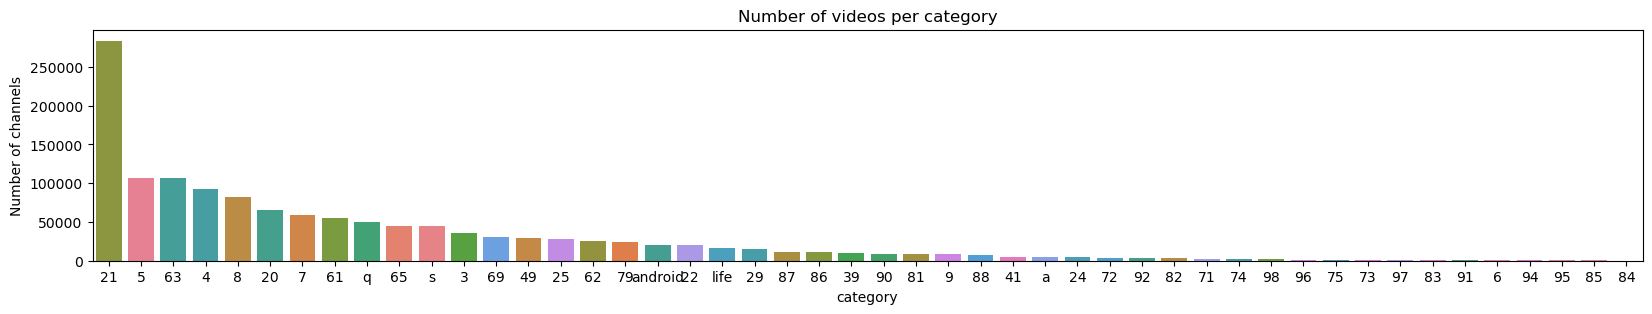

In [132]:
import matplotlib.pyplot as plt 
import seaborn as sns

to_plot = edu[edu.category != 'unclass'].copy().drop(columns = ['text'])

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(x='category', data=to_plot, order = to_plot.category.value_counts().index, hue = 'category', ax=ax)
#ax.set_yscale('log')
ax.set_title('Number of videos per category')
ax.set_xlabel('category')
ax.set_ylabel('Number of channels')
#ax.legend_.remove()
plt.show()
del to_plot

In [ ]:
# Check classification
key = '91'
edu[edu.category == key].sample(10).text.values